## The models accurracy

In this workbook we will be how to create a rolling forecast model with predictbitcoin10. We will be using out of sample data from the Feb 2021 to 5th March 2021; let's load some of the required packages.

In [10]:
import sagemaker
import os
import boto3
import sagemaker
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns


## Data
The data has been sourced from www.cryptodatadownload.com lets have a look at the dataset.

In [11]:
conn = boto3.client('s3')

data_location = 's3://cryptodatafiles/Bitstamp_BTCUSD_minute_5.csv'

payload = pd.read_csv(data_location)

payload = payload.iloc[::-1]

payload.head(10)

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
108918,1606031820,22/11/2020 07:57,BTC/USD,18494.17,18511.57,18485.07,18511.57,1.471611,27241.827260
108917,1606031880,22/11/2020 07:58,BTC/USD,18504.96,18517.30,18504.57,18517.30,1.535443,28432.253480
108916,1606031940,22/11/2020 07:59,BTC/USD,18521.33,18527.41,18511.13,18520.98,4.143530,76742.234040
108915,1606032000,22/11/2020 08:00,BTC/USD,18511.86,18519.25,18494.31,18494.31,3.089814,57143.974630
108914,1606032060,22/11/2020 08:01,BTC/USD,18493.49,18512.82,18493.49,18512.82,1.200447,22223.664410
108913,1606032120,22/11/2020 08:02,BTC/USD,18504.93,18514.36,18495.22,18495.22,1.424318,26343.068290
108912,1606032180,22/11/2020 08:03,BTC/USD,18497.45,18501.13,18497.45,18501.13,0.110696,2048.009597
108911,1606032240,22/11/2020 08:04,BTC/USD,18484.60,18485.51,18461.16,18461.16,3.239465,59804.286110
108910,1606032300,22/11/2020 08:05,BTC/USD,18460.01,18485.89,18460.01,18479.45,1.521050,28108.167420
108909,1606032360,22/11/2020 08:06,BTC/USD,18471.02,18487.95,18458.18,18487.32,2.300028,42521.348280


We will look at the tail of the dataset and plot movement over the period

In [12]:
payload.tail(10)

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
9,1614925380,05/03/2021 06:23,BTC/USD,47187.46,47187.46,47139.98,47142.51,1.003829,47323.00123
8,1614925440,05/03/2021 06:24,BTC/USD,47133.83,47133.83,47096.81,47107.60,2.629915,123888.97070
7,1614925500,05/03/2021 06:25,BTC/USD,47099.71,47150.84,47099.71,47113.21,1.874093,88294.53848
6,1614925560,05/03/2021 06:26,BTC/USD,47119.97,47160.64,47119.58,47160.63,1.247858,58849.75009
5,1614925620,05/03/2021 06:27,BTC/USD,47164.98,47164.98,47139.70,47139.70,1.075240,50686.50658
4,1614925680,05/03/2021 06:28,BTC/USD,47149.53,47151.15,47133.78,47144.77,1.081293,50977.31827
3,1614925740,05/03/2021 06:29,BTC/USD,47128.39,47128.39,47039.74,47043.57,2.907433,136776.03770
2,1614925800,05/03/2021 06:30,BTC/USD,47030.44,47124.47,47030.44,47105.35,2.590564,122029.44230
1,1614925860,05/03/2021 06:31,BTC/USD,47066.70,47070.34,47041.28,47041.28,1.055015,49629.25555
0,1614925920,05/03/2021 06:32,BTC/USD,47041.28,47041.28,47041.28,47041.28,0.000000,0.00000


<AxesSubplot:xlabel='date', ylabel='open'>

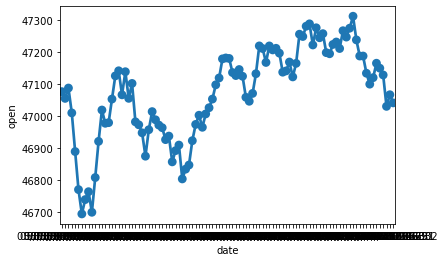

In [41]:
newdatabtc = payload
graph = payload.tail(100)
sns.pointplot(x="date", y="open", data=graph)

## Rolling Forecast
We will create a rolling forecast using the model: 
1. First we will create the required transformations using the 2 weeks of data prior to final period 
2. forecast the next 100 minutes by adding and removing 1 minute each time.

In [14]:
from sklearn import metrics

#### building the dataset
We create the dataset for forecasting we create an average using high and low and rename this Weighted_Price the dependent variable of the model.

In [15]:
databtc = payload.drop(['unix','date','symbol'], axis=1)
databtc = databtc[['high','open','low','close','Volume BTC','Volume USD']]
databtc.columns = ['High','Open','Low','Close','Volume_BTC','Volume_Currency']
databtc['Weighted_Price'] = (databtc['High']+databtc['Low'])/2
databtc = databtc[['High','Open','Low','Close','Weighted_Price','Volume_BTC','Volume_Currency']]
databtc = databtc.iloc[88659:108919,:]
databtc.head(10)

,High,Open,Low,Close,Weighted_Price,Volume_BTC,Volume_Currency
20259,51144.28,51116.28,51105.14,51105.14,51124.710,0.540892,2.764238e+04
20258,51111.72,51088.69,51068.04,51111.72,51089.880,1.005840,5.141020e+04
20257,51119.39,51119.39,51088.61,51116.83,51104.000,0.767281,3.922098e+04
20256,51145.12,51089.70,51089.70,51116.02,51117.410,0.242747,1.240826e+04
20255,51152.77,51123.60,51123.60,51152.77,51138.185,3.002847,1.536039e+05
20254,51158.76,51150.75,51122.26,51136.02,51140.510,21.904855,1.120127e+06
20253,51144.48,51144.48,51116.44,51125.36,51130.460,3.600157,1.840593e+05
20252,51200.00,51132.76,51132.76,51200.00,51166.380,1.923844,9.850081e+04
20251,51253.01,51200.00,51200.00,51244.49,51226.505,2.765488,1.417160e+05
20250,51300.83,51232.39,51232.39,51242.35,51266.610,7.483869,3.834910e+05


#### Model enpdoint
We build the model endpoint in the the next step.

In [22]:
content_type='text/csv'
model_name='bitcoinpredict10'
real_time_inference_instance_type='ml.m5.large'

# Please use the appropriate ARN obtained after subscribing to the model to define 'model_package_arn'
model_package_arn = 'arn:aws:sagemaker:eu-west-1:151286855433:model-package/bitcoinpredict10'

from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role

role = get_execution_role()
sagemaker_session = sage.Session()

#Define predictor wrapper class
def predict_wrapper(endpoint, session):
    return sage.predictor.Predictor(endpoint, session,content_type=content_type)
#create a deployable model from the model package.
model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

In [23]:
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

-----------------!

content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


#### Rolling Forecast function
The function below splits the data and using the panda rolling function to send the data to the model endpoint.

In [24]:
from io import StringIO

def callmodelroll(ser):
    dba =databtc.loc[ser.index]
    py = dba.to_csv(index=False)
    prediction = predictor.predict(py)
    s=str(prediction,'utf-8')
    prediction =s.split(":")
    prediction = prediction[1]
    prediction = prediction.split(",")
    prediction = prediction[0]
    print(prediction)
    prediction = float(prediction)
    return prediction

rol = databtc.Weighted_Price.rolling(window=20160)
df_data= rol.apply(callmodelroll, raw=False)


47035.4412
47178.6578
47135.7797
47153.3645
47037.7141
46814.9979
46880.4409
46840.1841
46814.4974
46623.8225
46726.9535
46580.6339
46498.4848
46604.2729
46688.441
46862.9521
46856.0903
47122.0993
47179.8012
47351.9334
47464.6302
47466.6577
47565.0025
47393.6295
47380.6072
47083.044
46881.7082
46958.0982
47081.2419
47043.4946
47214.0581
47168.063
47228.0716
47165.1749
47215.2959
47187.1758
47160.5071
47210.5737
47067.7509
47023.3728
46806.0527
46794.9779
46862.3419
46892.215
46900.2398
47013.6029
47177.2905
47233.3333
47414.2391
47485.8802
47638.5424
47481.5396
47563.7717
47572.1056
47635.9426
47554.3569
47524.5717
47417.8196
47476.1553
47560.237
47531.6295
47452.2067
47460.1711
47507.7853
47408.9957
47440.6291
47512.2123
47534.4055
47592.2492
47557.6509
47483.4626
47459.626
47402.1937
47460.5027
47316.4691
47331.7521
47324.3262
47425.2504
47501.9486
47589.7914
47562.3465
47650.9406
47736.4527
47589.2103
47585.8059
47609.5687
47530.9091
47393.9828
47368.4046
47416.0751
47446.2739
47450

In [25]:
databtc.shape[0]
act_pred = df_data.dropna()
act_pred

100    47035.4412
99     47178.6578
98     47135.7797
97     47153.3645
96     47037.7141
          ...    
4      47159.7199
3      47146.1701
2      47105.7351
1      47033.9871
0      47168.0077
Name: Weighted_Price, Length: 101, dtype: float64

In [26]:
act_pred=act_pred.tail(90)

In [28]:
payload.iloc[108829:108919,:]

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
89,1614920580,05/03/2021 05:03,BTC/USD,46808.38,46909.76,46796.46,46893.33,7.003111,328399.20970
88,1614920640,05/03/2021 05:04,BTC/USD,46921.27,47002.07,46921.00,47002.07,1.283648,60334.12396
87,1614920700,05/03/2021 05:05,BTC/USD,47019.00,47032.40,46918.26,46996.73,2.663086,125156.35340
86,1614920760,05/03/2021 05:06,BTC/USD,46977.65,46996.97,46954.13,46995.43,1.160378,54532.44098
85,1614920820,05/03/2021 05:07,BTC/USD,46979.63,47073.90,46948.01,47045.14,3.785271,178078.58670
...,...,...,...,...,...,...,...,...,...
4,1614925680,05/03/2021 06:28,BTC/USD,47149.53,47151.15,47133.78,47144.77,1.081293,50977.31827
3,1614925740,05/03/2021 06:29,BTC/USD,47128.39,47128.39,47039.74,47043.57,2.907433,136776.03770
2,1614925800,05/03/2021 06:30,BTC/USD,47030.44,47124.47,47030.44,47105.35,2.590564,122029.44230
1,1614925860,05/03/2021 06:31,BTC/USD,47066.70,47070.34,47041.28,47041.28,1.055015,49629.25555


In [29]:
act=(payload.iloc[108829:108919,5]+payload.iloc[108829:108919,6])/2
act


89    46844.895
88    46961.535
87    46957.495
86    46974.780
85    46996.575
        ...    
4     47139.275
3     47041.655
2     47067.895
1     47041.280
0     47041.280
Length: 90, dtype: float64

In [30]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(act,act_pred )

0.005512716770066628

Next we show the prediction error on the timeseries using the percentage error.

In [31]:
errors = ((act-act_pred)/act)*100
errors

89    0.564119
88    0.986020
87    0.752217
86    0.609559
85    0.284325
        ...   
4    -0.043371
3    -0.222176
2    -0.080395
1     0.015503
0    -0.269397
Length: 90, dtype: float64

In [34]:
import statistics
statistics.mean(errors)

-0.4359859212877497

In [35]:
statistics.median(errors)

-0.5273907408974625